In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures, scale
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import datetime
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('600K US Housing Properties.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   property_url        600000 non-null  object 
 1   property_id         600000 non-null  int64  
 2   address             600000 non-null  object 
 3   street_name         599869 non-null  object 
 4   apartment           14815 non-null   object 
 5   city                599999 non-null  object 
 6   state               599999 non-null  object 
 7   latitude            529122 non-null  float64
 8   longitude           529122 non-null  float64
 9   postcode            599970 non-null  object 
 10  price               600000 non-null  float64
 11  bedroom_number      443845 non-null  float64
 12  bathroom_number     471733 non-null  float64
 13  price_per_unit      435365 non-null  float64
 14  living_space        447847 non-null  float64
 15  land_space          515119 non-nul

In [4]:
description = df.describe(include='all')
description

,property_url,property_id,address,street_name,apartment,city,state,latitude,longitude,postcode,...,property_type,property_status,year_build,total_num_units,listing_age,RunDate,agency_name,agent_name,agent_phone,is_owned_by_zillow
count,600000,6.000000e+05,600000,599869,14815,599999,599999,529122.000000,529122.000000,599970,...,600000,600000,0.0,0.0,600000.0,600000,444524,0.0,0.0,600000.000000
unique,600000,NaN,598588,339224,2664,7977,25,NaN,NaN,10820,...,7,2,NaN,NaN,NaN,1,34372,NaN,NaN,NaN
top,https://www.zillow.com/homedetails/3-Plat-83-1...,NaN,"(undisclosed Address), Rockport, TX 78382",(undisclosed Address),1,Chicago,TX,NaN,NaN,84043,...,SINGLE_FAMILY,FOR_SALE,NaN,NaN,NaN,2022-04-24 07:34:15,Coldwell Banker Realty,NaN,NaN,NaN
freq,1,NaN,36,1713,312,14138,146636,NaN,NaN,1102,...,354366,383365,NaN,NaN,NaN,600000,5936,NaN,NaN,NaN
mean,NaN,8.885042e+08,NaN,NaN,NaN,NaN,NaN,36.282379,-105.813906,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000498
std,NaN,9.724708e+08,NaN,NaN,NaN,NaN,NaN,5.673355,13.464633,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.022318
min,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,18.985142,-165.408250,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
25%,NaN,5.402143e+07,NaN,NaN,NaN,NaN,NaN,32.612112,-117.346079,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
50%,NaN,2.066090e+08,NaN,NaN,NaN,NaN,NaN,35.403568,-101.897378,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000
75%,NaN,2.066867e+09,NaN,NaN,NaN,NaN,NaN,39.661674,-95.354245,NaN,...,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,0.000000


In [5]:
df.columns

Index(['property_url', 'property_id', 'address', 'street_name', 'apartment',
       'city', 'state', 'latitude', 'longitude', 'postcode', 'price',
       'bedroom_number', 'bathroom_number', 'price_per_unit', 'living_space',
       'land_space', 'land_space_unit', 'broker_id', 'property_type',
       'property_status', 'year_build', 'total_num_units', 'listing_age',
       'RunDate', 'agency_name', 'agent_name', 'agent_phone',
       'is_owned_by_zillow'],
      dtype='object')

In [6]:
df = df.drop(df[df.property_type == 'LOT'].index)
df = df.drop(df[df.living_space == 0].index)
df = df.drop(df[df.price == 0].index)
df = df[df.state == 'TX']

In [7]:
#Land space is an important metric for the price of the house but this dataset has multiple units
#All the values with 'acres' unit changed to 'sqft'
df.loc[df['land_space_unit']=='acres', 'land_space'] = df['land_space']*43560.00
df.loc[df['land_space_unit']=='acres', 'land_space_unit']='sqft'
df[['land_space','land_space_unit']]

,land_space,land_space_unit
180271,6969.600,sqft
180273,12632.400,sqft
180275,11325.600,sqft
180277,15246.000,sqft
180279,6000.000,sqft
...,...,...
446346,8145.720,sqft
446348,3920.400,sqft
446350,4356.000,sqft
446352,4299.372,sqft


In [8]:
df = df.drop(columns=['property_url', 'property_id', 'address', 'street_name', 'apartment', 'city', 'state', 'price_per_unit', 'land_space_unit', 'broker_id','property_status', 'year_build', 'total_num_units', 'listing_age',
       'RunDate', 'agency_name', 'agent_name', 'agent_phone',
       'is_owned_by_zillow'])

In [9]:
description = df.describe(include='all')
description

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type
count,102318.000000,102318.000000,113297,1.132970e+05,110799.000000,112676.000000,1.109490e+05,9.127400e+04,113297
unique,NaN,NaN,1661,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,75126,NaN,NaN,NaN,NaN,NaN,SINGLE_FAMILY
freq,NaN,NaN,964,NaN,NaN,NaN,NaN,NaN,101682
mean,30.810231,-97.110881,NaN,5.191826e+05,3.440031,2.679117,2.484810e+03,2.915174e+05,NaN
std,1.726681,1.946499,NaN,7.836710e+05,1.023723,1.195078,3.747852e+04,9.626307e+06,NaN
min,25.860826,-106.631890,NaN,1.000000e+00,0.000000,0.000000,1.000000e+00,-1.089000e+04,NaN
25%,29.694795,-97.961078,NaN,2.728000e+05,3.000000,2.000000,1.590000e+03,6.124134e+03,NaN
50%,30.263153,-96.948185,NaN,3.800000e+05,3.000000,3.000000,2.052000e+03,8.424504e+03,NaN
75%,32.557445,-95.545932,NaN,5.499000e+05,4.000000,3.000000,2.698000e+03,1.769734e+04,NaN


In [10]:
df.isna().sum()

latitude           10979
longitude          10979
postcode               0
price                  0
bedroom_number      2498
bathroom_number      621
living_space        2348
land_space         22023
property_type          0
dtype: int64

In [11]:
df['postcode']=df['postcode'].astype(str)

In [12]:
df.groupby(['postcode'])['latitude'].median()

postcode
 78245    29.396170
11111     33.599007
73870     27.943542
75001     32.953060
75002     33.093969
            ...    
79934     31.938034
79935     31.772724
79936     31.766772
79938     31.797543
97316     29.350270
Name: latitude, Length: 1661, dtype: float64

In [13]:
df.isna().sum()

latitude           10979
longitude          10979
postcode               0
price                  0
bedroom_number      2498
bathroom_number      621
living_space        2348
land_space         22023
property_type          0
dtype: int64

In [14]:
#filling the rest with median values
df['bedroom_number'] = df['bedroom_number'].fillna(df['bedroom_number'].median())
df['bathroom_number'] = df['bathroom_number'].fillna(df['bathroom_number'].median())
df['living_space'] = df['living_space'].fillna(df['living_space'].median())
df['land_space'] = df['land_space'].fillna(df['land_space'].median())
df = df.dropna(subset=['latitude', 'longitude'])

In [15]:
df.isna().sum()

latitude           0
longitude          0
postcode           0
price              0
bedroom_number     0
bathroom_number    0
living_space       0
land_space         0
property_type      0
dtype: int64

In [16]:
df.head()

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type
180271,31.786737,-106.42802,79903,239500.0,5.0,3.0,1692.0,6969.6,SINGLE_FAMILY
180273,31.784021,-106.40445,79925,165000.0,4.0,2.0,1650.0,12632.4,SINGLE_FAMILY
180275,31.761911,-106.43233,79905,118000.0,4.0,1.0,1918.0,11325.6,SINGLE_FAMILY
180277,31.790165,-106.43596,79903,414700.0,4.0,3.0,3119.0,15246.0,SINGLE_FAMILY
180279,31.775480,-106.43823,79905,260000.0,3.0,3.0,3267.0,6000.0,MULTI_FAMILY


In [17]:
new1 = df[df['postcode']=='76227']
new1.head()

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type
398371,33.205257,-97.11697,76227,627220.0,4.0,3.0,3187.0,21780.00,SINGLE_FAMILY
401629,33.233730,-96.91788,76227,864990.0,5.0,4.0,3701.0,9104.04,SINGLE_FAMILY
401634,33.261505,-96.88623,76227,452900.0,3.0,2.0,2038.0,5749.92,SINGLE_FAMILY
401638,33.246227,-96.90582,76227,579000.0,5.0,4.0,3274.0,7230.96,SINGLE_FAMILY
401643,33.222060,-96.91457,76227,975000.0,5.0,4.0,4133.0,7492.32,SINGLE_FAMILY


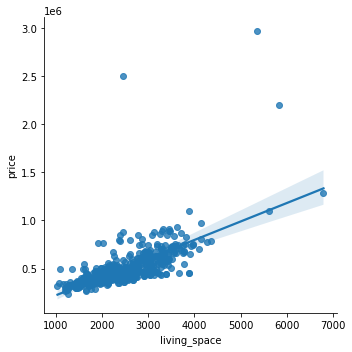

In [18]:
lmplot = sns.lmplot(x="living_space", y="price", data=new1)

In [19]:
# A crucial categorical feature 'property_type' is categorical variable so I wanted to transform that to a numeric one
dummies=pd.get_dummies(df[['postcode','property_type']], drop_first=True)
dummies

,postcode_11111,postcode_73870,postcode_75001,postcode_75002,postcode_75006,postcode_75007,postcode_75009,postcode_75010,postcode_75013,postcode_75017,...,postcode_79934,postcode_79935,postcode_79936,postcode_79938,postcode_97316,property_type_CONDO,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
df = pd.concat([df,dummies],axis='columns')
df

,latitude,longitude,postcode,price,bedroom_number,bathroom_number,living_space,land_space,property_type,postcode_11111,...,postcode_79934,postcode_79935,postcode_79936,postcode_79938,postcode_97316,property_type_CONDO,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,31.786737,-106.428020,79903,239500.0,5.0,3.0,1692.0,6969.600,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
180273,31.784021,-106.404450,79925,165000.0,4.0,2.0,1650.0,12632.400,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
180275,31.761911,-106.432330,79905,118000.0,4.0,1.0,1918.0,11325.600,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,-106.435960,79903,414700.0,4.0,3.0,3119.0,15246.000,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
180279,31.775480,-106.438230,79905,260000.0,3.0,3.0,3267.0,6000.000,MULTI_FAMILY,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,-96.710945,75023,393000.0,3.0,2.0,1717.0,8145.720,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,-96.707720,75023,315000.0,3.0,3.0,1754.0,3920.400,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,-96.712920,75023,360000.0,4.0,3.0,2068.0,4356.000,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,-96.713900,75023,447000.0,4.0,3.0,2111.0,4299.372,SINGLE_FAMILY,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
df = df.drop(columns=['postcode','property_type'])
df

,latitude,longitude,price,bedroom_number,bathroom_number,living_space,land_space,postcode_11111,postcode_73870,postcode_75001,...,postcode_79934,postcode_79935,postcode_79936,postcode_79938,postcode_97316,property_type_CONDO,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,31.786737,-106.428020,239500.0,5.0,3.0,1692.0,6969.600,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180273,31.784021,-106.404450,165000.0,4.0,2.0,1650.0,12632.400,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180275,31.761911,-106.432330,118000.0,4.0,1.0,1918.0,11325.600,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,-106.435960,414700.0,4.0,3.0,3119.0,15246.000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180279,31.775480,-106.438230,260000.0,3.0,3.0,3267.0,6000.000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,-96.710945,393000.0,3.0,2.0,1717.0,8145.720,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,-96.707720,315000.0,3.0,3.0,1754.0,3920.400,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,-96.712920,360000.0,4.0,3.0,2068.0,4356.000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,-96.713900,447000.0,4.0,3.0,2111.0,4299.372,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
df.dtypes

latitude                       float64
longitude                      float64
price                          float64
bedroom_number                 float64
bathroom_number                float64
                                ...   
property_type_CONDO              uint8
property_type_MANUFACTURED       uint8
property_type_MULTI_FAMILY       uint8
property_type_SINGLE_FAMILY      uint8
property_type_TOWNHOUSE          uint8
Length: 1640, dtype: object

In [23]:
df["price_per_sqfoot"] = df["price"] / df["living_space"]

In [24]:
q_low = df["bedroom_number"].quantile(0.01)
q_hi  = df["bedroom_number"].quantile(0.99)

df = df[(df["bedroom_number"] < q_hi) & (df["bedroom_number"] > q_low)]

In [25]:
q_low = df["bathroom_number"].quantile(0.01)
q_hi  = df["bathroom_number"].quantile(0.99)

df = df[(df["bathroom_number"] < q_hi) & (df["bathroom_number"] > q_low)]

In [26]:
q_low = df["living_space"].quantile(0.01)
q_hi  = df["living_space"].quantile(0.99)

df = df[(df["living_space"] < q_hi) & (df["living_space"] > q_low)]

In [27]:
q_low = df["land_space"].quantile(0.01)
q_hi  = df["land_space"].quantile(0.99)

df = df[(df["land_space"] < q_hi) & (df["land_space"] > q_low)]

In [28]:
q_low = df["price"].quantile(0.01)
q_hi  = df["price"].quantile(0.99)

df = df[(df["price"] < q_hi) & (df["price"] > q_low)]

In [29]:
q_low = df["price_per_sqfoot"].quantile(0.01)
q_hi  = df["price_per_sqfoot"].quantile(0.99)

df = df[(df["price_per_sqfoot"] < q_hi) & (df["price_per_sqfoot"] > q_low)]

In [30]:
description = df.describe(include='all')
description

,latitude,longitude,price,bedroom_number,bathroom_number,living_space,land_space,postcode_11111,postcode_73870,postcode_75001,...,postcode_79935,postcode_79936,postcode_79938,postcode_97316,property_type_CONDO,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE,price_per_sqfoot
count,88538.000000,88538.000000,8.853800e+04,88538.000000,88538.000000,88538.000000,8.853800e+04,88538.000000,88538.000000,88538.000000,...,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000,88538.000000
mean,30.821253,-97.119096,4.227666e+05,3.451264,2.656735,2177.081558,2.789358e+04,0.000011,0.000011,0.000136,...,0.000147,0.000689,0.001965,0.000011,0.023527,0.021177,0.009295,0.916409,0.029524,192.998559
std,1.705725,1.943535,2.253386e+05,0.716987,0.866572,766.587002,9.036039e+04,0.003361,0.003361,0.011641,...,0.012117,0.026239,0.044288,0.003361,0.151570,0.143976,0.095964,0.276775,0.169271,69.368485
min,25.860826,-106.631890,7.600000e+04,2.000000,1.000000,841.000000,1.455000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.677871
25%,29.688561,-97.959947,2.735000e+05,3.000000,2.000000,1604.000000,6.708240e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,147.997383
50%,30.246199,-96.967766,3.719000e+05,3.000000,3.000000,2045.000000,8.424504e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,180.836000
75%,32.578172,-95.554955,5.149000e+05,4.000000,3.000000,2635.000000,1.089000e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,222.155947
max,36.461475,-93.589455,1.680000e+06,5.000000,5.500000,4897.000000,1.202692e+06,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,524.580336


In [31]:
features=df.describe().columns.drop(['price', 'price_per_sqfoot'])
features

Index(['latitude', 'longitude', 'bedroom_number', 'bathroom_number',
       'living_space', 'land_space', 'postcode_11111', 'postcode_73870',
       'postcode_75001', 'postcode_75002',
       ...
       'postcode_79934', 'postcode_79935', 'postcode_79936', 'postcode_79938',
       'postcode_97316', 'property_type_CONDO', 'property_type_MANUFACTURED',
       'property_type_MULTI_FAMILY', 'property_type_SINGLE_FAMILY',
       'property_type_TOWNHOUSE'],
      dtype='object', length=1639)

In [32]:
targets=['price','price_per_sqfoot']
targets

['price', 'price_per_sqfoot']

In [33]:
X=df[features]
X

,latitude,longitude,bedroom_number,bathroom_number,living_space,land_space,postcode_11111,postcode_73870,postcode_75001,postcode_75002,...,postcode_79934,postcode_79935,postcode_79936,postcode_79938,postcode_97316,property_type_CONDO,property_type_MANUFACTURED,property_type_MULTI_FAMILY,property_type_SINGLE_FAMILY,property_type_TOWNHOUSE
180271,31.786737,-106.428020,5.0,3.0,1692.0,6969.600,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180273,31.784021,-106.404450,4.0,2.0,1650.0,12632.400,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180277,31.790165,-106.435960,4.0,3.0,3119.0,15246.000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180279,31.775480,-106.438230,3.0,3.0,3267.0,6000.000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
180281,31.785316,-106.411150,4.0,2.0,1800.0,6098.400,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446346,33.059647,-96.710945,3.0,2.0,1717.0,8145.720,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446348,33.044098,-96.707720,3.0,3.0,1754.0,3920.400,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446350,33.069946,-96.712920,4.0,3.0,2068.0,4356.000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
446352,33.070004,-96.713900,4.0,3.0,2111.0,4299.372,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
y=df[targets[0]]
y

180271    239500.0
180273    165000.0
180277    414700.0
180279    260000.0
180281    174950.0
            ...   
446346    393000.0
446348    315000.0
446350    360000.0
446352    447000.0
446354    377000.0
Name: price, Length: 88538, dtype: float64

In [35]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.3,random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test)

(61976, 26562, 61976, 26562)

In [36]:
numeric=['latitude', 'longitude', 'bedroom_number', 'bathroom_number', 'living_space', 'land_space']
sc=StandardScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

**Linear Regression Model**

In [37]:
model = LinearRegression()
model.fit(X_train , y_train)

LinearRegression()

In [38]:
y_pred = model.predict(X_test)

In [39]:
from sklearn import metrics
print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred, squared=False))

6849888622153.035
1.253942063450609e+29
354110443710801.75


In [40]:
model.score(X_train , y_train)

0.7546124073687953

**Ridge Regression Model**

In [41]:
clf = Ridge(alpha=0.1)
clf.fit(X_train , y_train)

Ridge(alpha=0.1)

In [42]:
clf_pred = clf.predict(X_test)

In [43]:
print(metrics.mean_absolute_error(y_test,clf_pred))
print(metrics.mean_squared_error(y_test,clf_pred))
print(metrics.mean_squared_error(y_test,clf_pred, squared=False))

77105.19901516492
12817140109.003838
113212.80894405826


In [44]:
clf.score(X_train , y_train)

0.7545884247611188

**Lasso Regression Model**

In [45]:
clf1 = Lasso(alpha=0.1)
clf1.fit(X_train , y_train)

Lasso(alpha=0.1)

In [46]:
clf1_pred = clf1.predict(X_test)

In [47]:
print(metrics.mean_absolute_error(y_test,clf1_pred))
print(metrics.mean_squared_error(y_test,clf1_pred))
print(metrics.mean_squared_error(y_test,clf1_pred, squared=False))

77109.71347973225
12817276915.068087
113213.41314114722


In [48]:
clf1.score(X_train , y_train)

0.7545983482611908